In [ ]:
import os
import re
import time
import logging
import pickle
import signal
import json
import concurrent.futures
import threading
from datetime import datetime
from functools import lru_cache
from typing import Optional, Dict, Any, Tuple, Set, List
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import pandas as pd
import numpy as np
from tqdm import tqdm
from ydata_profiling import ProfileReport
import matplotlib as plt
import seaborn as sns



data = pd.read_pickle(r'C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\processed_data\combined_dataset.pkl')
subset_data = data.dropna(subset=['final_worldwide_boxoffice', 
                                        'final_budget', 
                                        'final_domestic_boxoffice'])
subset_data.to_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\data.csv",index=False)


Dataset shape: (9798, 23)
Number of duplicate rows: 0 (0.00%)



Missing values by column (%):
star_id                       51.07%
star                          51.07%
director                      51.07%
director_id                   51.07%
final_production_countries    46.72%
final_rating                  46.72%
production_companies          46.72%
imdb_id                       46.72%
final_original_language       46.72%
crew                          46.72%
final_overview                46.72%
cast                          46.72%
final_certificate             42.03%
final_runtime                 38.41%
final_genres                  37.82%
release_date                   1.52%
final_year                     1.52%
final_title                    0.00%
final_budget                   0.00%
final_clean_title              0.00%
final_domestic_boxoffice       0.00%
final_worldwide_boxoffice      0.00%
_merge                         0.00%
dtype: object


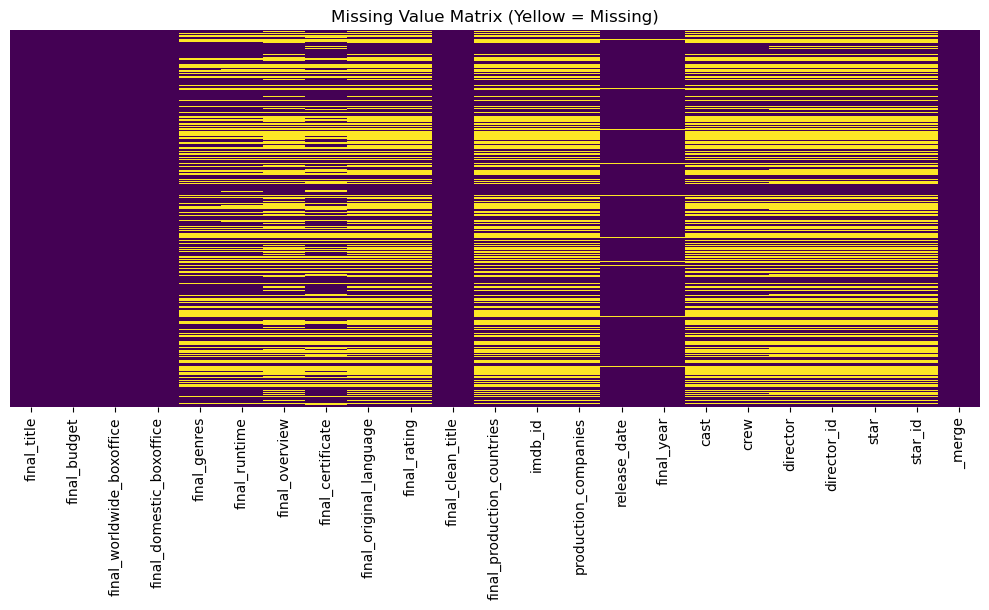

In [21]:
missing = subset_data.isna().mean().sort_values(ascending=False)
print("\nMissing values by column (%):")
print(missing.apply(lambda x: f"{x:.2%}"))

plt.figure(figsize=(10, 6))
sns.heatmap(subset_data.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.title('Missing Value Matrix (Yellow = Missing)')
plt.show()

In [ ]:

OMDB_API_KEY = 'ccc9c4b6'  # OMDb API key
TMDB_API_KEY = '464f3e996afaffb22d3a2230433aa2a4'  # TMDb API key

# Logger Setup 
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

# Helper Function 
def parse_iso8601_duration(duration_str: Optional[str]) -> Optional[int]:
    """Convert ISO 8601 duration (e.g., PT2H30M) to total minutes."""
    if not duration_str or not isinstance(duration_str, str) or not duration_str.startswith('PT'):
        return None
    hours, minutes = 0, 0
    hour_match = re.search(r'(\d+)H', duration_str)
    minute_match = re.search(r'(\d+)M', duration_str)
    try:
        if hour_match:
            hours = int(hour_match.group(1))
        if minute_match:
            minutes = int(minute_match.group(1))
    except ValueError:
        return None
    total_minutes = (hours * 60) + minutes
    return total_minutes if total_minutes > 0 else None

# Main Class
class MovieDataEnricher:
    """
    Enrich movie datasets using OMDb and TMDb APIs (OMDb is prioritized).
    Features include concurrency, rate limiting, retries, caching, pause/resume, and secure API key management.
    """
    ENRICHMENT_COLUMNS = [
        'imdb_id', 'certificate', 'director', 'rating', 'runtime', 'star',
        'genres', 'production_countries', 'original_language', 'production_companies',
        'enrichment_source'
    ]
    NUMERIC_COLUMNS = ['rating', 'runtime']
    OMDB_URL = 'http://www.omdbapi.com/'
    TMDB_API_BASE_URL = 'https://api.themoviedb.org/3'

    def __init__(self,
                 omdb_api_key: Optional[str] = OMDB_API_KEY,
                 tmdb_api_key: Optional[str] = TMDB_API_KEY,
                 max_workers: int = 10,
                 rate_limit_per_second: float = 10.0):
        self.omdb_api_key = omdb_api_key
        self.tmdb_api_key = tmdb_api_key
        self.max_workers = max(1, max_workers)
        self.rate_limit_per_second = max(0.1, rate_limit_per_second)
        self.min_interval_api = 1.0 / self.rate_limit_per_second
        self.last_request_time = 0.0
        self.rate_limit_lock = threading.Lock()
        self.logger = logging.getLogger(self.__class__.__name__)
        if not self.omdb_api_key:
            self.logger.warning("OMDb API key missing. OMDb lookups disabled.")
        if not self.tmdb_api_key:
            self.logger.warning("TMDb API key missing. TMDb lookups disabled.")
        if not self.omdb_api_key and not self.tmdb_api_key:
            self.logger.critical("No API keys provided. Cannot fetch data.")
        self.session = self._create_session()
        self.stats = {
            'total_movies': 0, 'attempted': 0, 'success_omdb_id': 0, 'success_omdb_title': 0,
            'success_tmdb': 0, 'skipped_no_title': 0, 'failed': 0, 'processed_indices': set()
        }
        self.checkpoint_file_base = None
        self.is_paused = False
        self.progress_bar: Optional[tqdm] = None

    def _create_session(self) -> requests.Session:
        session = requests.Session()
        headers = {
            'User-Agent': 'MovieDataEnricherScript/1.0',
            'Accept-Language': 'en-US,en;q=0.9',
            'Accept': 'application/json'
        }
        session.headers.update(headers)
        retry_strategy = Retry(
            total=3, backoff_factor=0.5,
            status_forcelist=[429, 500, 502, 503, 504],
            allowed_methods=["GET"]
        )
        adapter = HTTPAdapter(
            max_retries=retry_strategy,
            pool_connections=self.max_workers,
            pool_maxsize=self.max_workers * 2
        )
        session.mount("http://", adapter)
        session.mount("https://", adapter)
        self.logger.info(f"Session created with retries and a connection pool of size {self.max_workers}.")
        return session

    def _initialize_columns(self, movies_df: pd.DataFrame) -> pd.DataFrame:
        """Ensure all enrichment columns exist with the correct data types."""
        for col in self.ENRICHMENT_COLUMNS:
            if col not in movies_df.columns:
                if col in self.NUMERIC_COLUMNS:
                    movies_df[col] = pd.Series(dtype=float)
                else:
                    movies_df[col] = pd.Series(dtype=object)
            elif col in self.NUMERIC_COLUMNS:
                movies_df[col] = pd.to_numeric(movies_df[col], errors='coerce')
        return movies_df

    @lru_cache(maxsize=2048)
    def _extract_year(self, date_value: Any) -> Optional[int]:
        if pd.isna(date_value):
            return None
        current_full_year = datetime.now().year
        future_year_limit = current_full_year + 5
        try:
            if isinstance(date_value, (int, float)) and 1880 <= int(date_value) <= future_year_limit:
                return int(date_value)
            if isinstance(date_value, (datetime, pd.Timestamp)):
                if 1880 <= date_value.year <= future_year_limit:
                    return date_value.year
            if isinstance(date_value, str):
                date_str = date_value.strip()
                if not date_str:
                    return None
                if re.fullmatch(r'(1[89]|20)\d{2}', date_str):
                    return int(date_str)
                year_match = re.search(r'\b(1[89]|20)\d{2}\b', date_str)
                if year_match:
                    return int(year_match.group(0))
                common_formats = ('%Y-%m-%d', '%m/%d/%Y', '%d-%b-%y', '%d-%b-%Y', '%B %d, %Y', '%Y', '%b %Y', '%b-%Y')
                for fmt in common_formats:
                    try:
                        dt_str = date_str.split(' ')[0].split('-')[0] if fmt == '%b-%Y' else date_str.split(' ')[0]
                        dt = datetime.strptime(dt_str, fmt)
                        if 1880 <= dt.year <= future_year_limit:
                            return dt.year
                    except (ValueError, TypeError):
                        continue
        except Exception as e:
            self.logger.debug(f"Year extraction failed for {date_value}: {e}")
        return None

    def _rate_limit(self):
        with self.rate_limit_lock:
            current_time = time.monotonic()
            elapsed = current_time - self.last_request_time
            wait_time = self.min_interval_api - elapsed
            if wait_time > 0:
                time.sleep(wait_time)
                self.last_request_time = time.monotonic()
            else:
                self.last_request_time = current_time

    def _save_checkpoint(self, movies_df: pd.DataFrame):
        if not self.checkpoint_file_base:
            return
        checkpoint_meta_file = self.checkpoint_file_base + '.meta'
        checkpoint_data_file = self.checkpoint_file_base + '.csv'
        checkpoint_data = {
            'processed_indices': list(self.stats['processed_indices']),
            'stats': {k: v for k, v in self.stats.items() if k != 'processed_indices'}
        }
        try:
            for col in self.NUMERIC_COLUMNS:
                if col in movies_df.columns:
                    movies_df[col] = pd.to_numeric(movies_df[col], errors='coerce')
            movies_df.to_csv(checkpoint_data_file, index=False)
            with open(checkpoint_meta_file, 'wb') as f:
                pickle.dump(checkpoint_data, f)
            self.logger.debug(f"Checkpoint saved with {len(self.stats['processed_indices'])} processed entries.")
        except Exception as e:
            self.logger.error(f"Error saving checkpoint: {e}", exc_info=True)

    def _load_checkpoint(self) -> Tuple[Optional[pd.DataFrame], bool]:
        if not self.checkpoint_file_base:
            return None, False
        checkpoint_meta_file = self.checkpoint_file_base + '.meta'
        checkpoint_data_file = self.checkpoint_file_base + '.csv'
        if os.path.exists(checkpoint_meta_file) and os.path.exists(checkpoint_data_file):
            try:
                with open(checkpoint_meta_file, 'rb') as f:
                    checkpoint_data = pickle.load(f)
                movies_df = pd.read_csv(checkpoint_data_file, low_memory=False)
                self.stats.update(checkpoint_data.get('stats', {}))
                default_stats = {k: 0 for k in self.stats if k != 'processed_indices'}
                for key in default_stats:
                    self.stats.setdefault(key, 0)
                self.stats['processed_indices'] = set(checkpoint_data.get('processed_indices', []))
                movies_df = self._initialize_columns(movies_df)
                self.logger.info(f"Loaded checkpoint with {len(self.stats['processed_indices'])} entries.")
                return movies_df, True
            except Exception as e:
                self.logger.error(f"Error loading checkpoint: {e}. Starting fresh.", exc_info=True)
                if os.path.exists(checkpoint_meta_file):
                    os.remove(checkpoint_meta_file)
                if os.path.exists(checkpoint_data_file):
                    os.remove(checkpoint_data_file)
                return None, False
        else:
            return None, False

    def _handle_interrupt(self, signum, frame):
        if not self.is_paused:
            self.logger.warning("Pause requested. Finishing current batch and saving checkpoint...")
            self.is_paused = True
            signal.signal(signal.SIGINT, signal.SIG_DFL)
            if self.progress_bar:
                self.progress_bar.set_description("Pausing...")

    def _cleanup_checkpoints(self):
        if self.checkpoint_file_base:
            meta_file = self.checkpoint_file_base + '.meta'
            data_file = self.checkpoint_file_base + '.csv'
            removed_count = 0
            try:
                if os.path.exists(meta_file):
                    os.remove(meta_file)
                    removed_count += 1
                if os.path.exists(data_file):
                    os.remove(data_file)
                    removed_count += 1
                if removed_count > 0:
                    self.logger.info(f"Removed {removed_count} checkpoint file(s).")
            except OSError as e:
                self.logger.warning(f"Could not remove checkpoint files: {e}")

    @lru_cache(maxsize=2048)
    def _find_tmdb_id(self, title: str, year: Optional[int] = None) -> Optional[int]:
        """Search TMDb API for a movie ID."""
        if not self.tmdb_api_key or not title:
            return None
        search_url = f"{self.TMDB_API_BASE_URL}/search/movie"
        params = {
            'api_key': self.tmdb_api_key,
            'query': title,
            'language': 'en-US',
            'include_adult': 'false'
        }
        log_identifier = f"'{title}'"
        if year:
            params['primary_release_year'] = year
            log_identifier += f" ({year})"
        self._rate_limit()
        try:
            response = self.session.get(search_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            results = data.get('results')
            if results:
                if year:
                    for res in results:
                        rd = res.get('release_date')
                        if rd and str(year) in rd:
                            return res.get('id')
                self.logger.debug(f"TMDb ID {results[0].get('id')} found for {log_identifier}.")
                return results[0].get('id')
            else:
                self.logger.debug(f"TMDb search did not find {log_identifier}.")
                return None
        except requests.exceptions.RequestException as e:
            self.logger.warning(f"TMDb search network error for {log_identifier}: {e}")
            return None
        except Exception as e:
            self.logger.error(f"TMDb search error for {log_identifier}: {e}", exc_info=False)
            return None

    def _enrich_with_omdb_api(self, title: Optional[str] = None, year: Optional[int] = None, imdb_id: Optional[str] = None) -> Optional[Dict[str, Any]]:
        """Fetch movie data from OMDb API."""
        if not self.omdb_api_key or (not imdb_id and not title):
            return None
        params = {'apikey': self.omdb_api_key, 'plot': 'short', 'r': 'json'}
        log_identifier = ""
        source = 'failed'
        if imdb_id:
            params['i'] = imdb_id
            log_identifier = f"IMDb ID {imdb_id}"
            source = 'omdb_id'
        elif title:
            params['t'] = title
            params['type'] = 'movie'
            log_identifier = f"'{title}'"
            source = 'omdb_title'
        if title and year:
            params['y'] = year
            log_identifier += f" ({year})"
        if 't' not in params and 'i' not in params:
            return None
        self._rate_limit()
        try:
            response = self.session.get(self.OMDB_URL, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            if data.get('Response') == 'True':
                movie_data = {col: np.nan for col in self.ENRICHMENT_COLUMNS}
                movie_data.update({
                    'imdb_id': data.get('imdbID'),
                    'certificate': data.get('Rated'),
                    'director': data.get('Director'),
                    'rating': pd.to_numeric(data.get('imdbRating'), errors='coerce'),
                    'star': data.get('Actors'),
                    'genres': data.get('Genre'),
                    'production_countries': data.get('Country'),
                    'original_language': data.get('Language'),
                    'production_companies': data.get('Production'),
                    'enrichment_source': source
                })
                runtime_str = data.get('Runtime')
                if runtime_str and runtime_str != 'N/A':
                    m = re.search(r'(\d+)', runtime_str)
                    movie_data['runtime'] = int(m.group(1)) if m else np.nan
                for k, v in movie_data.items():
                    if isinstance(v, str) and v.strip().upper() in ['N/A', 'NONE', '']:
                        movie_data[k] = np.nan
                    elif k in self.NUMERIC_COLUMNS and v == 0:
                        movie_data[k] = np.nan
                return movie_data
            else:
                error_msg = data.get('Error', 'Unknown')
                if source == 'omdb_id' or "not found" not in error_msg.lower():
                    self.logger.debug(f"OMDb API error for {log_identifier}: {error_msg}")
                return None
        except requests.exceptions.RequestException as e:
            self.logger.warning(f"OMDb API network error for {log_identifier}: {e}")
            return None
        except ValueError as e:
            self.logger.warning(f"OMDb JSON decode error for {log_identifier}: {e}")
            return None
        except Exception as e:
            self.logger.error(f"OMDb API unexpected error for {log_identifier}: {e}", exc_info=False)
            return None

    def _enrich_with_tmdb_api(self, tmdb_id: int) -> Optional[Dict[str, Any]]:
        """Fetch movie data from TMDb API."""
        if not self.tmdb_api_key or not tmdb_id:
            return None
        details_url = f"{self.TMDB_API_BASE_URL}/movie/{tmdb_id}"
        params = {
            'api_key': self.tmdb_api_key,
            'language': 'en-US',
            'append_to_response': 'credits,release_dates'
        }
        self._rate_limit()
        try:
            response = self.session.get(details_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()
            movie_data = {col: np.nan for col in self.ENRICHMENT_COLUMNS}
            movie_data['enrichment_source'] = 'tmdb'
            movie_data['imdb_id'] = data.get('imdb_id') or np.nan
            movie_data['runtime'] = data.get('runtime')
            movie_data['genres'] = ', '.join([g['name'] for g in data.get('genres', [])])
            spoken_langs = data.get('spoken_languages', [])
            movie_data['original_language'] = spoken_langs[0]['english_name'] if spoken_langs else np.nan
            movie_data['production_countries'] = ', '.join([c['name'] for c in data.get('production_countries', [])])
            movie_data['production_companies'] = ', '.join([c['name'] for c in data.get('production_companies', [])])
            movie_data['rating'] = data.get('vote_average')
            credits = data.get('credits', {})
            cast = credits.get('cast', [])
            crew = credits.get('crew', [])
            if cast:
                movie_data['star'] = ', '.join([a['name'] for a in cast[:4]])
            directors = [p['name'] for p in crew if p.get('job') == 'Director']
            movie_data['director'] = ', '.join(directors) if directors else np.nan
            release_dates = data.get('release_dates', {}).get('results', [])
            us_cert = None
            for rd in release_dates:
                if rd.get('iso_3166_1') == 'US':
                    for r in rd.get('release_dates', []):
                        cert = r.get('certification')
                        if cert:
                            us_cert = cert
                            break
                if us_cert:
                    break
            movie_data['certificate'] = us_cert
            for k, v in movie_data.items():
                if v is None or (isinstance(v, (str, list, dict)) and not v):
                    movie_data[k] = np.nan
                elif k in self.NUMERIC_COLUMNS and v == 0:
                    movie_data[k] = np.nan
            return movie_data
        except requests.exceptions.RequestException as e:
            self.logger.warning(f"TMDb details network error ID {tmdb_id}: {e}")
            return None
        except Exception as e:
            self.logger.error(f"TMDb details error ID {tmdb_id}: {e}", exc_info=False)
            return None

    def _process_movie(self, args: Tuple[int, pd.Series, str, Optional[str]]) -> Tuple[int, Optional[Dict[str, Any]], str]:
        """Process a single movie using OMDb and TMDb APIs."""
        index, row, title_column, _ = args
        title = row.get(title_column)
        if pd.isna(title) or not isinstance(title, str) or not title.strip():
            return index, None, 'skipped_no_title'
        title = title.strip()
        year = row.get('extracted_year')
        result_data: Optional[Dict[str, Any]] = None
        source: str = 'failed'
        existing_imdb_id = row.get('_input_imdb_id')
        if pd.isna(existing_imdb_id) or not isinstance(existing_imdb_id, str) or not existing_imdb_id.startswith('tt'):
            existing_imdb_id = None

        # Attempt enrichment using OMDb API first
        if self.omdb_api_key:
            if existing_imdb_id:
                result_data = self._enrich_with_omdb_api(imdb_id=existing_imdb_id)
            if not result_data:
                result_data = self._enrich_with_omdb_api(title=title, year=year)
            if result_data:
                source = result_data.get('enrichment_source', 'omdb_title')

        # Fallback to TMDb API if OMDb fails
        if not result_data and self.tmdb_api_key:
            tmdb_id = self._find_tmdb_id(title, year)
            if tmdb_id:
                result_data = self._enrich_with_tmdb_api(tmdb_id)
            if result_data:
                source = result_data.get('enrichment_source', 'tmdb')

        if result_data:
            final_imdb_id = result_data.get('imdb_id')
            if source == 'tmdb' and pd.isna(final_imdb_id) and existing_imdb_id:
                result_data['imdb_id'] = existing_imdb_id
            elif source != 'tmdb' and existing_imdb_id and pd.isna(final_imdb_id):
                result_data['imdb_id'] = existing_imdb_id
            return index, result_data, source
        else:
            self.logger.debug(f"Failed to enrich '{title}' ({year}) using APIs.")
            return index, None, 'failed'

    def enrich_dataset(self,
                       input_path: str,
                       output_path: str,
                       title_column: str = 'movie_title',
                       year_column: Optional[str] = None,
                       imdb_id_column: Optional[str] = 'imdb_id',
                       limit: Optional[int] = None,
                       resume: bool = True,
                       checkpoint_interval: int = 50,
                       batch_size: int = 50) -> pd.DataFrame:
        """Load, enrich, and save the movie dataset."""
        start_time = time.time()
        self.is_paused = False
        output_dir = os.path.dirname(output_path) or '.'
        os.makedirs(output_dir, exist_ok=True)
        self.checkpoint_file_base = os.path.join(output_dir, os.path.basename(output_path) + ".checkpoint")
        initial_processed_count = 0
        signal.signal(signal.SIGINT, self._handle_interrupt)

        movies_df: Optional[pd.DataFrame] = None
        loaded_from_checkpoint = False
        if resume:
            movies_df, loaded_from_checkpoint = self._load_checkpoint()
        if loaded_from_checkpoint and movies_df is not None:
            initial_processed_count = len(self.stats['processed_indices'])

        if not loaded_from_checkpoint or movies_df is None:
            self.logger.info("Starting a new enrichment process.")
            self.stats = {k: (set() if k == 'processed_indices' else 0) for k in self.stats.keys()}
            initial_processed_count = 0
            try:
                self.logger.info(f"Loading dataset from: {input_path}")
                movies_df = pd.read_csv(input_path, low_memory=False)
                self.logger.info(f"Dataset loaded with {len(movies_df)} rows.")
            except FileNotFoundError:
                self.logger.critical(f"Input file not found: {input_path}")
                raise
            except Exception as e:
                self.logger.critical(f"Error loading input CSV {input_path}: {e}", exc_info=True)
                raise

            if title_column not in movies_df.columns:
                possible_titles = [c for c in movies_df.columns if 'title' in c.lower() or 'movie' in c.lower() or 'name' in c.lower()]
                if possible_titles:
                    title_column = possible_titles[0]
                    self.logger.info(f"Auto-detected title column: '{title_column}'")
                else:
                    raise ValueError(f"Title column '{title_column}' not found.")
            if year_column and year_column not in movies_df.columns:
                self.logger.warning(f"Year column '{year_column}' not found.")
                year_column = None
            if imdb_id_column and imdb_id_column not in movies_df.columns:
                self.logger.info(f"Input IMDb ID column '{imdb_id_column}' not found.")
                imdb_id_column = None

            if limit and limit < len(movies_df):
                self.logger.info(f"Limiting processing to the first {limit} rows.")
                movies_df = movies_df.head(limit).copy()
            self.stats['total_movies'] = len(movies_df)
            
            movies_df = self._initialize_columns(movies_df)
            movies_df['_input_imdb_id'] = movies_df[imdb_id_column].astype(str) if imdb_id_column else np.nan
            movies_df['extracted_year'] = movies_df[year_column].apply(self._extract_year) if year_column else np.nan
            if year_column:
                self.logger.info(f"Year extraction complete with {movies_df['extracted_year'].notna().sum()} valid entries.")

        if movies_df is None:
            raise RuntimeError("Failed to load or initialize DataFrame.")
        self.stats['_initial_processed_count'] = initial_processed_count

        all_indices = set(movies_df.index)
        indices_to_process = sorted(list(all_indices - self.stats['processed_indices']))

        if not indices_to_process:
            self.logger.info("No new movies to process. Saving current state.")
            for col in ['_input_imdb_id', 'extracted_year']:
                if col in movies_df.columns:
                    movies_df = movies_df.drop(columns=[col])
            try:
                movies_df.to_csv(output_path, index=False)
                self._cleanup_checkpoints()
            except Exception as e:
                self.logger.error(f"Error saving final data: {e}")
            return movies_df

        self.logger.info(f"Starting API enrichment for {len(indices_to_process)} movies.")
        self.progress_bar = tqdm(total=self.stats['total_movies'], initial=len(self.stats['processed_indices']),
                                 desc="Enriching(API)", unit="movie")
        processed_in_session = 0

        try:
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_workers, thread_name_prefix='ApiEnricher') as executor:
                futures_map: Dict[concurrent.futures.Future, int] = {}
                indices_iter = iter(indices_to_process)
                for _ in range(min(batch_size * 2, len(indices_to_process))):
                    try:
                        idx = next(indices_iter)
                        row_data = movies_df.loc[idx]
                        args = (idx, row_data, title_column, year_column)
                        futures_map[executor.submit(self._process_movie, args)] = idx
                        self.stats['attempted'] += 1
                    except StopIteration:
                        break
                while futures_map:
                    if self.is_paused:
                        break
                    done_futures, _ = concurrent.futures.wait(futures_map.keys(), return_when=concurrent.futures.FIRST_COMPLETED)
                    for future in done_futures:
                        idx = futures_map.pop(future)
                        if idx in self.stats['processed_indices']:
                            continue
                        try:
                            _, result_data, source = future.result()
                            if result_data:
                                for key, value in result_data.items():
                                    if key in movies_df.columns:
                                        movies_df.loc[idx, key] = value
                            if source == 'skipped_no_title':
                                self.stats['skipped_no_title'] += 1
                            elif source == 'failed':
                                self.stats['failed'] += 1
                            else:
                                stat_key = f"success_{source}"
                                self.stats[stat_key] = self.stats.get(stat_key, 0) + 1
                        except Exception as e:
                            self.logger.error(f"Error processing result idx {idx}: {e}", exc_info=False)
                            self.stats['failed'] += 1
                        finally:
                            self.stats['processed_indices'].add(idx)
                            processed_in_session += 1
                            self.progress_bar.update(1)
                            if processed_in_session > 0 and processed_in_session % checkpoint_interval == 0:
                                self._save_checkpoint(movies_df)
                    if not self.is_paused:
                        for _ in range(len(done_futures)):
                            try:
                                idx = next(indices_iter)
                                row_data = movies_df.loc[idx]
                                args = (idx, row_data, title_column, year_column)
                                futures_map[executor.submit(self._process_movie, args)] = idx
                                self.stats['attempted'] += 1
                            except StopIteration:
                                break
                    if self.is_paused:
                        break
        except KeyboardInterrupt:
            self.logger.critical("Force exit requested.")
            self.is_paused = True
        finally:
            if self.progress_bar:
                self.progress_bar.close()
            signal.signal(signal.SIGINT, signal.SIG_DFL)
            for col in ['_input_imdb_id', 'extracted_year']:
                if col in movies_df.columns:
                    movies_df = movies_df.drop(columns=[col])
            if self.is_paused:
                self.logger.warning("Paused. Saving checkpoint.")
                self._save_checkpoint(movies_df)
            else:
                self.logger.info("Finished. Saving final data.")
                try:
                    for col in self.NUMERIC_COLUMNS:
                        if col in movies_df.columns:
                            movies_df[col] = pd.to_numeric(movies_df[col], errors='coerce')
                    movies_df.to_csv(output_path, index=False)
                    self.logger.info("Dataset saved successfully.")
                    self._cleanup_checkpoints()
                except Exception as e:
                    self.logger.critical(f"Failed to save final output: {e}", exc_info=True)
                    self.logger.warning("Data may be available in the checkpoint file.")
            self._log_final_stats(start_time)
            if self.is_paused:
                self.logger.warning("Paused. Resume by running the script again with the same arguments.")
        return movies_df

    def _log_final_stats(self, start_time: float):
        
        end_time = time.time()
        duration = end_time - start_time
        total_processed = len(self.stats['processed_indices'])
        initial_count = self.stats.get('_initial_processed_count', 0)
        processed_this_run = total_processed - initial_count
        self.logger.info("\n--- Enrichment Summary (API Only) ---")
        self.logger.info(f"Total time: {duration:.2f} seconds")
        self.logger.info(f"Dataset size: {self.stats['total_movies']}")
        self.logger.info(f"Processed in this run: {processed_this_run}")
        self.logger.info(f"Overall processed: {total_processed}/{self.stats['total_movies']}")
        if total_processed > 0:
            success_total = self.stats['success_omdb_id'] + self.stats['success_omdb_title'] + self.stats['success_tmdb']
            self.logger.info("API Success Breakdown:")
            omdb_id_count = self.stats.get('success_omdb_id', 0)
            omdb_title_count = self.stats.get('success_omdb_title', 0)
            tmdb_count = self.stats.get('success_tmdb', 0)
            skip_count = self.stats.get('skipped_no_title', 0)
            fail_count = self.stats.get('failed', 0)
            if self.omdb_api_key:
                omdb_id_perc = omdb_id_count / total_processed * 100 if total_processed else 0
                omdb_title_perc = omdb_title_count / total_processed * 100 if total_processed else 0
                self.logger.info(f"  OMDb (by ID):    {omdb_id_count} ({omdb_id_perc:.1f}%)")
                self.logger.info(f"  OMDb (by Title): {omdb_title_count} ({omdb_title_perc:.1f}%)")
            if self.tmdb_api_key:
                tmdb_perc = tmdb_count / total_processed * 100 if total_processed else 0
                self.logger.info(f"  TMDb:            {tmdb_count} ({tmdb_perc:.1f}%)")
            success_perc = success_total / total_processed * 100 if total_processed else 0
            skip_perc = skip_count / total_processed * 100 if total_processed else 0
            fail_perc = fail_count / total_processed * 100 if total_processed else 0
            self.logger.info(f"  Total Success:      {success_total} ({success_perc:.1f}%)")
            self.logger.info(f"  Skipped (No Title): {skip_count} ({skip_perc:.1f}%)")
            self.logger.info(f"  Failed (Both APIs): {fail_count} ({fail_perc:.1f}%)")
        else:
            self.logger.info("No movies were processed.")
        self.logger.info("---------------------------------------\n")


if __name__ == "__main__":
    
    INPUT_CSV_PATH = r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\data.csv"
    OUTPUT_CSV_PATH = r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\enriched_data.csv"
    TITLE_COLUMN_NAME = 'movie_title'
    YEAR_COLUMN_NAME = 'release_date'
    IMDB_ID_INPUT_COLUMN = 'imdb_id'

    ROW_LIMIT = None  # Process all rows
    MAX_WORKERS = 10
    RATE_LIMIT = 10.0
    CHECKPOINT_INTERVAL = 100
    BATCH_SIZE = 100
    FORCE_NO_RESUME = False

    if not OMDB_API_KEY and not TMDB_API_KEY:
        logging.critical("No API keys provided. Please set valid API keys in the script.")
    elif not OMDB_API_KEY:
        logging.warning("OMDb API key not found. Using TMDb only.")
    elif not TMDB_API_KEY:
        logging.warning("TMDb API key not found. Using OMDb only.")

    try:
        enricher = MovieDataEnricher(
            omdb_api_key=OMDB_API_KEY,
            tmdb_api_key=TMDB_API_KEY,
            max_workers=MAX_WORKERS,
            rate_limit_per_second=RATE_LIMIT
        )
        enriched_df = enricher.enrich_dataset(
            input_path=INPUT_CSV_PATH,
            output_path=OUTPUT_CSV_PATH,
            title_column=TITLE_COLUMN_NAME,
            year_column=YEAR_COLUMN_NAME,
            imdb_id_column=IMDB_ID_INPUT_COLUMN,
            limit=ROW_LIMIT,
            resume=not FORCE_NO_RESUME,
            checkpoint_interval=CHECKPOINT_INTERVAL,
            batch_size=BATCH_SIZE
        )
        logging.info("Script execution finished.")
    except FileNotFoundError:
        logging.critical(f"Input file '{INPUT_CSV_PATH}' not found.")
    except ValueError as ve:
        logging.critical(f"Configuration or Data Error: {ve}")
    except Exception as e:
        logging.critical(f"Unexpected error: {e}", exc_info=True)


C:\Users\divya\AppData\Local\Temp\ipykernel_10484\4102965032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data.drop(columns=columns_to_drop, errors="ignore", inplace=True)


Dataset shape: (9798, 19)
Number of duplicate rows: 0 (0.00%)

Missing values by column (%):
certificate                  16.20%
production_companies         14.37%
production_countries         10.22%
rating                       10.03%
original_language             9.85%
genres                        9.26%
runtime                       9.22%
enrichment_source             8.84%
star                          8.67%
imdb_id                       8.62%
director                      8.44%
final_year                    1.52%
release_date                  1.52%
_merge                        0.00%
final_budget                  0.00%
final_clean_title             0.00%
final_domestic_boxoffice      0.00%
final_worldwide_boxoffice     0.00%
final_title                   0.00%
dtype: object


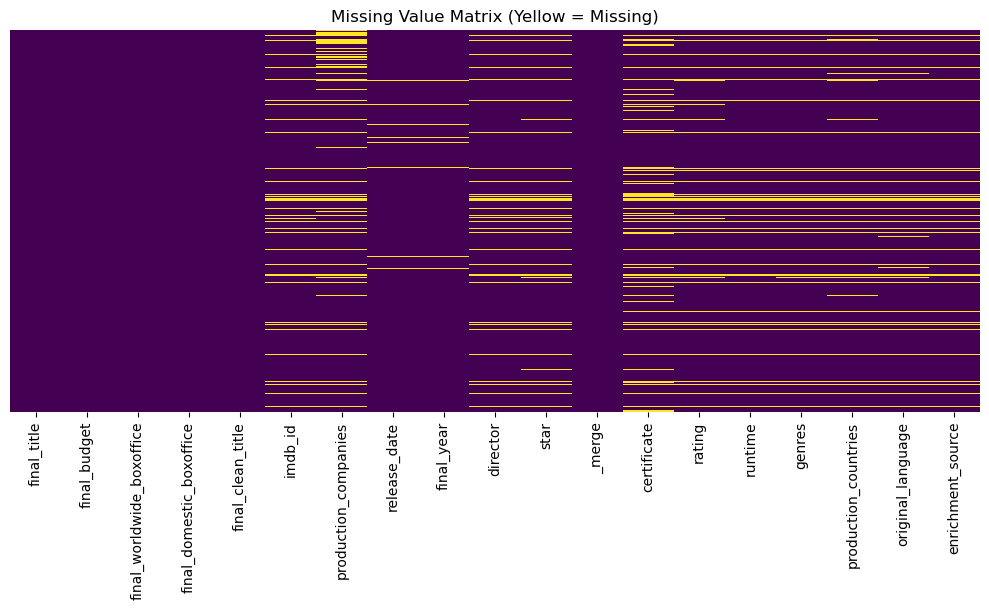

In [25]:
df = pd. read_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\enriched_data.csv")
df = df.drop(columns=["final_genres", "final_runtime", "final_overview", "final_original_language", "final_rating", "final_production_countries", "cast", "crew", "director_id", "star_id","final_certificate" ], errors='ignore')


print(f"Dataset shape: {df.shape}")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates} ({duplicates/len(df):.2%})")

missing = df.isna().mean().sort_values(ascending=False)
print("\nMissing values by column (%):")
print(missing.apply(lambda x: f"{x:.2%}"))

plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.title('Missing Value Matrix (Yellow = Missing)')
plt.show()


Data types:
final_title                   object
final_budget                 float64
final_worldwide_boxoffice    float64
final_domestic_boxoffice     float64
final_clean_title             object
imdb_id                       object
production_companies          object
release_date                  object
final_year                   float64
director                      object
star                          object
_merge                        object
certificate                   object
rating                       float64
runtime                      float64
genres                        object
production_countries          object
original_language             object
enrichment_source             object
dtype: object


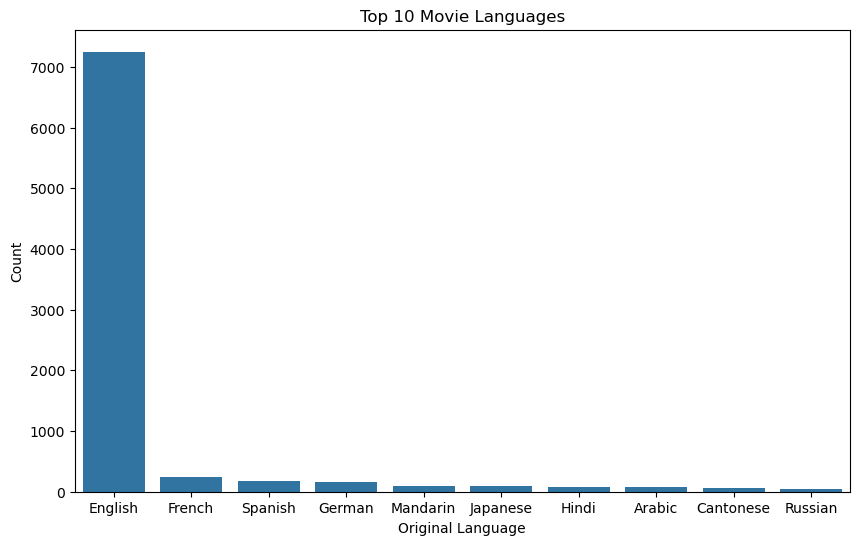

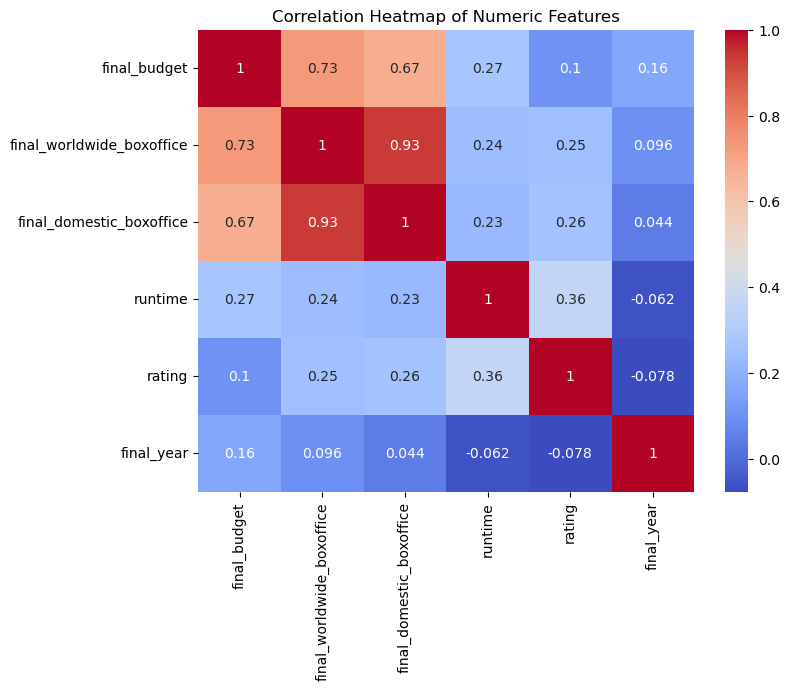

In [28]:
print("\nData types:")
print(df.dtypes)
plt.figure(figsize=(10, 6))
lang_counts = df['original_language'].value_counts().head(10)
sns.barplot(x=lang_counts.index, y=lang_counts.values)
plt.title("Top 10 Movie Languages")
plt.xlabel("Original Language")
plt.ylabel("Count")
plt.show()

numeric_cols = ['final_budget', 'final_worldwide_boxoffice', 'final_domestic_boxoffice', 'runtime', 'rating', 'final_year']
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()




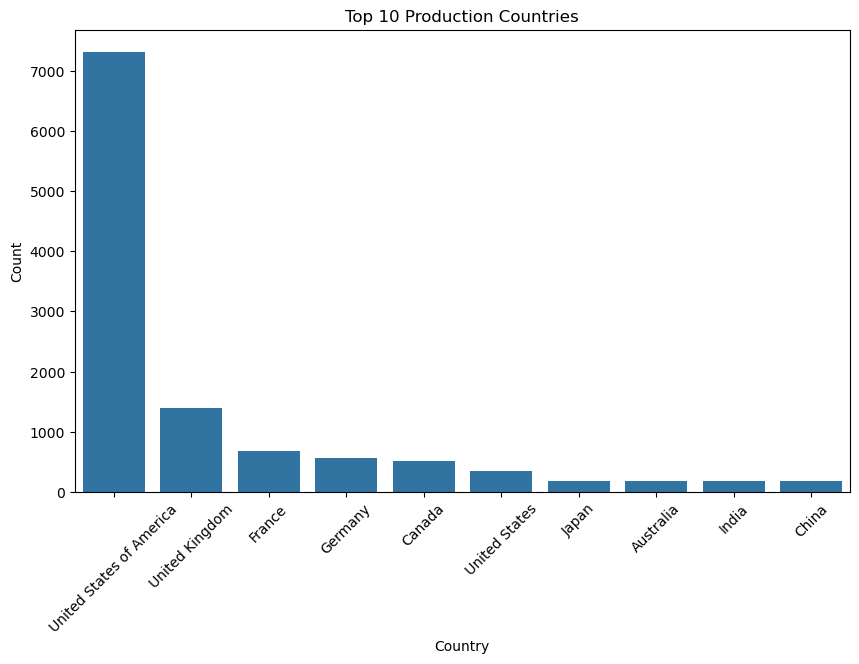

In [30]:


# Split the production countries for each movie 
countries = df['production_countries'].dropna().apply(lambda x: x.split(","))
countries_list = list(itertools.chain.from_iterable(countries))
countries_list = [c.strip() for c in countries_list]
country_counts = collections.Counter(countries_list)
top_countries = pd.DataFrame.from_dict(country_counts, orient="index", columns=["Count"]).sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries["Count"])
plt.title("Top 10 Production Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [31]:
profile = ProfileReport(df, title="Movie Dataset Profiling Report")
profile.to_file("movie_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 98.81it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]